In [244]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ
from matplotlib import cm
from scipy.stats import qmc
from sbi.inference import NLE


def update_cosmo_pars_dict(fid_pars_dict, varied_pars, nreal, lhc):
    """Update the cosmo_pars dict with the sampled values"""
    cosmo_pars = {}
    for i, par in enumerate(varied_pars):
        cosmo_pars[par] = lhc[:, i]
    for par in fid_pars_dict:
        if par not in varied_pars:
            cosmo_pars[par] = np.repeat(fid_pars_dict[par], nreal)
    return cosmo_pars


### Settings

In [245]:
n_samples = 2000
n_dim = 5
n_components = n_dim

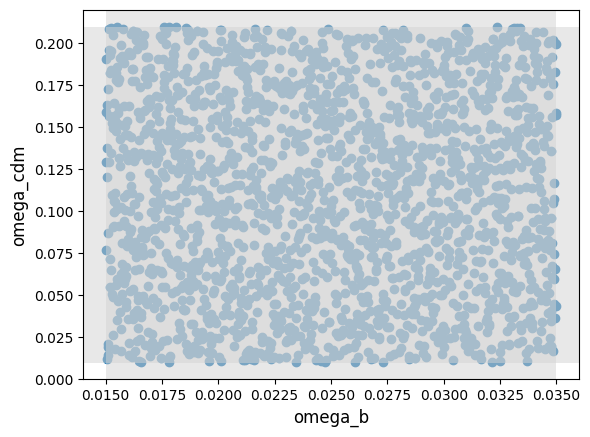

In [246]:
# define fiducials and prior bounds
fid_pars_dict = {
    'omega_b': np.array([0.025]),
    'omega_cdm': np.array([0.11]),
    'h': np.array([0.68]),
    'n_s': np.array([0.97]),
    'ln10^{10}A_s': np.array([3.1]),
    'eta_0': np.array([0.7]),
    'cmin': np.array([2.6]),
    'z': np.array([0.0]),
}
prior_bounds_dict = {
    'omega_b': np.array(
        [fid_pars_dict['omega_b'][0] - 0.01, fid_pars_dict['omega_b'][0] + 0.01]
    ),
    'omega_cdm': np.array(
        [fid_pars_dict['omega_cdm'][0] - 0.1, fid_pars_dict['omega_cdm'][0] + 0.1]
    ),
    'h': np.array([fid_pars_dict['h'][0] - 0.1, fid_pars_dict['h'][0] + 0.1]),
    'n_s': np.array([fid_pars_dict['n_s'][0] - 0.1, fid_pars_dict['n_s'][0] + 0.1]),
    'ln10^{10}A_s': np.array(
        [fid_pars_dict['ln10^{10}A_s'][0] - 0.5, fid_pars_dict['ln10^{10}A_s'][0] + 0.5]
    ),
}

# the parameters to vary and nuisance
varied_par_names = list(fid_pars_dict.keys())[:n_dim]
nuisance_par_names = set(fid_pars_dict) ^ set(varied_par_names)

# Latin hypercube
sampler = qmc.LatinHypercube(d=n_dim)
lhc = sampler.random(n=n_samples)


# shift and stretch the hypercube values
for i, par in enumerate(varied_par_names):
    lhc[:, i] = (
        lhc[:, i] * (prior_bounds_dict[par][1] - prior_bounds_dict[par][0])
        + prior_bounds_dict[par][0]
    )

# take a look at the omega_b, omega_cdm slice
plt.scatter(lhc[:, 0], lhc[:, 1])
plt.axvspan(
    prior_bounds_dict['omega_b'][0],
    prior_bounds_dict['omega_b'][1],
    facecolor='lightgray',
    alpha=0.5,
)
plt.axhspan(
    prior_bounds_dict['omega_cdm'][0],
    prior_bounds_dict['omega_cdm'][1],
    facecolor='lightgray',
    alpha=0.5,
)
plt.xlabel('omega_b', fontsize=12)
plt.ylabel('omega_cdm', fontsize=12)
plt.show()


### Simulate (emulate) datavectors $P(k)$

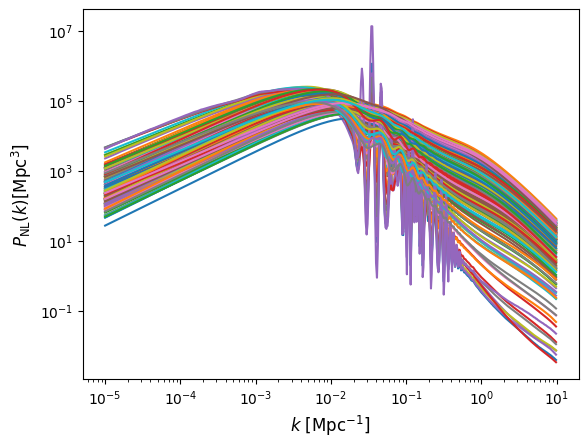

In [247]:
cosmo_pars = update_cosmo_pars_dict(fid_pars_dict, varied_par_names, n_samples, lhc)

emulator = CPJ(probe='mpk_nonlin')
dv = emulator.predict(cosmo_pars)  # dv = datavector

# and compare
for i in range(n_samples)[::10]:
    plt.loglog(emulator.modes, dv[i, :])
plt.xlabel(r'$k$ [Mpc$^{-1}]$', fontsize=12)
plt.ylabel(r'$P_{\mathrm{NL}}(k) [\mathrm{Mpc}^3]$', fontsize=12)
plt.show()

# Compress data with PCA

Compute data covariance matrix

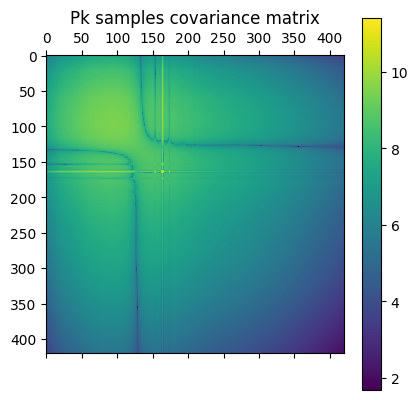

In [248]:
# Compute the datavector covariance matrix
cov = np.cov(dv, rowvar=False)

plt.matshow(np.log10(np.abs(cov)))
plt.colorbar()
plt.title('Pk samples covariance matrix')
plt.show()

Compute eigenvalues and eigenvectors

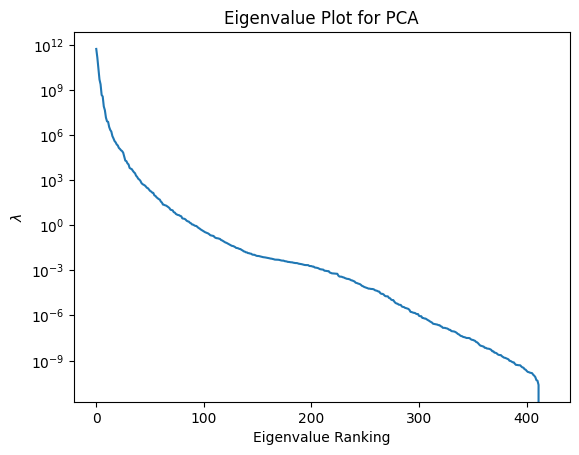

In [249]:
# np's eigh returns lambda and vectors in increasing order of lambda
evals, evecs = np.linalg.eigh(cov)
evals = evals[::-1]
evecs = evecs[:, ::-1]

plt.figure()
plt.plot(evals)
plt.yscale('log')
plt.ylabel(r'$\lambda$')
plt.title('Eigenvalue Plot for PCA')
plt.xlabel('Eigenvalue Ranking')
plt.show()

Cut to `n_components` and compress the datavectors

In [250]:
# cut to ndim components
evecs = evecs[:, :n_components]

# compress datavector
compressed_dv = np.array(dv @ evecs)

De-compress to check if the PCA succedeed

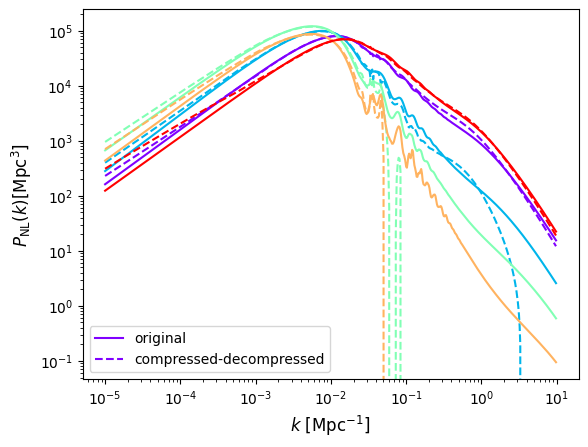

In [251]:
# de-compress to check if the PCA succedeed
pca_decompressed_dv = np.array(compressed_dv @ evecs.T)

nspectra = 5
colors = cm.rainbow(np.linspace(0, 1, nspectra))
for i in range(n_samples)[:nspectra]:
    label_orig = 'original' if i == 0 else None
    label_dec = 'compressed-decompressed' if i == 0 else None
    plt.loglog(emulator.modes, dv[i, :], c=colors[i], label=label_orig)
    plt.loglog(
        emulator.modes, pca_decompressed_dv[i, :], ls='--', c=colors[i], label=label_dec
    )
plt.xlabel(r'$k$ [Mpc$^{-1}]$', fontsize=12)
plt.ylabel(r'$P_{\mathrm{NL}}(k) [\mathrm{Mpc}^3]$', fontsize=12)
plt.legend()
plt.show()

# Try with CCA

Compute parameter-data covariance. This maximizes mutual information between parameters and compressed data vector

<Figure size 640x480 with 0 Axes>

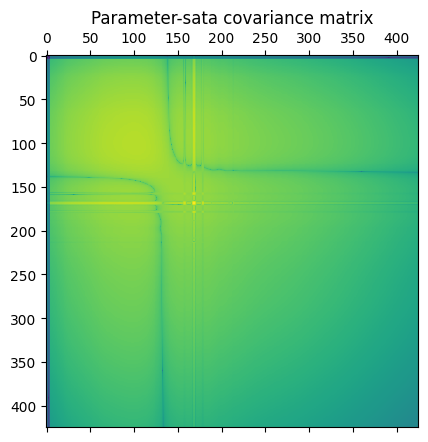

In [252]:
pars_matrix = np.vstack([cosmo_pars[par] for par in varied_par_names]).T
nuis_matrix = np.vstack([cosmo_pars[par] for par in nuisance_par_names]).T

# Compute the sampled parameter auto covariance, simulated data vector auto covariance
# and the parameter-data vector cross covariance
cov = np.cov(np.vstack([pars_matrix.T, dv.T]), rowvar=True)
cov_2 = np.cov(pars_matrix.T, dv.T)
np.testing.assert_equal(cov, cov_2)

plt.figure()
plt.matshow(np.log10(np.abs(cov)))
plt.title('Parameter-sata covariance matrix')

plt.show()

Cut it to get the individual blocks: \
cp = parameter covariance \
cd = data covariance \
cpd = parameter-data covariance

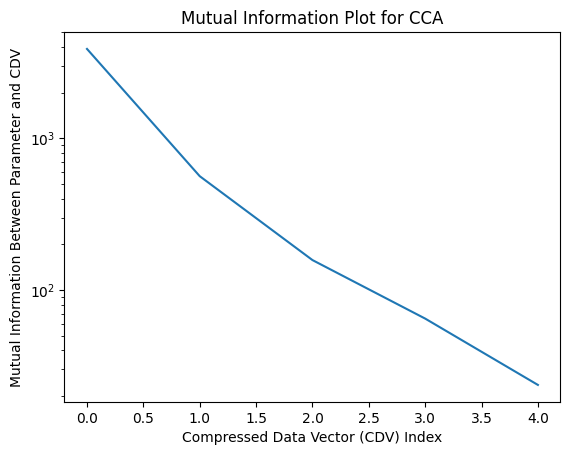

In [253]:
cp = cov[:n_dim, :n_dim]
cd = cov[n_dim:, n_dim:]
cpd = cov[:n_dim, n_dim:]

# This 'cl' can be understood as the projection of 'cp' to data parameter space
cl = cpd.T @ np.linalg.inv(cp) @ cpd

# As seen in the paper, this generalized eigenvalue problem is equivalent to CCA
# but is more numerical stable as 'cd' and 'cd-cl' are both invertible.
# This problem is motivated as mutual information maximization under
# Gaussian linear model assumptions
evals, evecs = scipy.linalg.eigh(cd, cd - cl)

# In the context of the CCA, only min(dim(param), dim(data vector) )
# components are real and the rest are noise.
evals = evals[::-1][:n_components]
evecs = evecs[:, ::-1][:, :n_components]

plt.title('Mutual Information Plot for CCA')
plt.xlabel('Compressed Data Vector (CDV) Index')
plt.ylabel('Mutual Information Between Parameter and CDV')
plt.semilogy(evals)
plt.show()

Check CCA reconstruction

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_74627/3134961886.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$P_{\mathrm{NL}}(k) [\mathrm{Mpc}^3]$', fontsize=12)


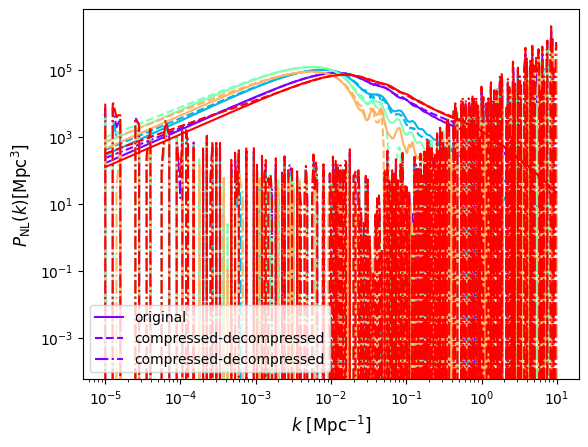

In [254]:
compressed_dv = dv @ evecs
cca_decompressed_dv = compressed_dv @ evecs.T

nspectra = 5
colors = cm.rainbow(np.linspace(0, 1, nspectra))
for i in range(n_samples)[:nspectra]:
    label_orig = 'original' if i == 0 else None
    label_dec = 'compressed-decompressed' if i == 0 else None
    plt.loglog(emulator.modes, dv[i, :], c=colors[i], label=label_orig)
    plt.loglog(
        emulator.modes, pca_decompressed_dv[i, :], ls='--', c=colors[i], label=label_dec
    )
    plt.loglog(
        emulator.modes, cca_decompressed_dv[i, :], ls='-.', c=colors[i], label=label_dec
    )
plt.xlabel('$k$ [Mpc$^{-1}]$', fontsize=12)
plt.ylabel('$P_{\mathrm{NL}}(k) [\mathrm{Mpc}^3]$', fontsize=12)
plt.legend()

That was bad, but CCA is not optimised for reconstruction (maximises the parameter-data information rather than the data-data one)

Text(0, 0.5, 'compressed data vector [0]')

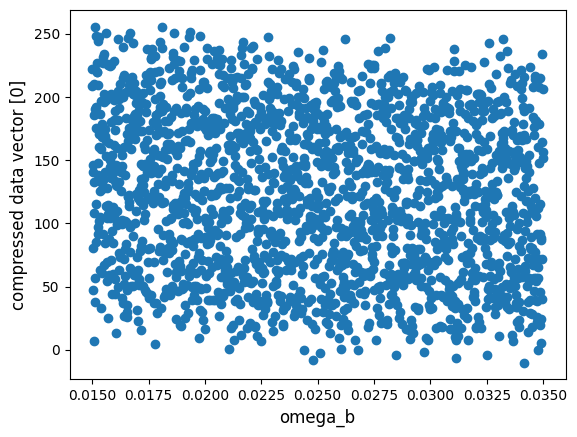

In [255]:
# add a colorbar based on the value of
plt.scatter(pars_matrix[:, 0], compressed_dv[:, 0])
plt.xlabel(varied_par_names[0], fontsize=12)
plt.ylabel('compressed data vector [0]', fontsize=12)

Text(0, 0.5, 'compressed data vector [2]')

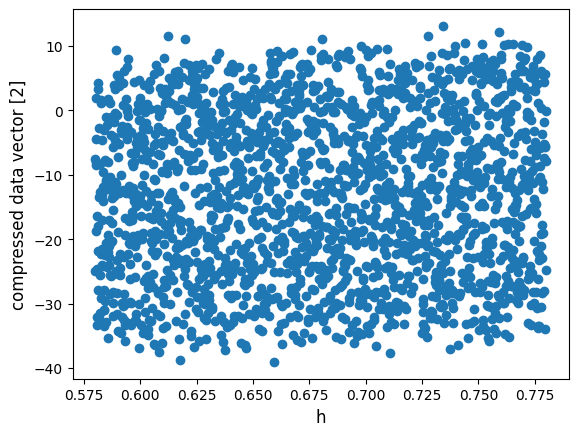

In [256]:
# add a colorbar based on the value of
plt.scatter(pars_matrix[:, 2], compressed_dv[:, 2])
plt.xlabel(varied_par_names[2], fontsize=12)
plt.ylabel('compressed data vector [2]', fontsize=12)

In [257]:
# turn the dict into an array
cosmo_pars_arr = np.zeros((n_samples, len(list(cosmo_pars.keys()))))
for i, param_vec in enumerate(cosmo_pars.values()):
    cosmo_pars_arr[:, i] = param_vec

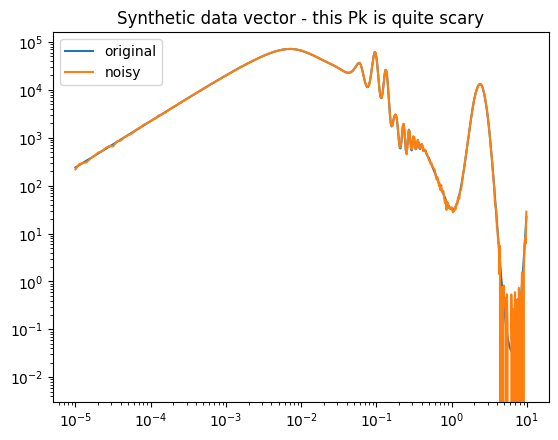

In [258]:
# create synthetic data vector
fid_pars_arr = np.array([v[0] for v in fid_pars_dict.values()])
obs_data = emulator.predict(fid_pars_arr)

# add some noise
# noisy_obs_data = obs_data + np.random.multivariate_normal(
# np.zeros(obs_data.shape[0]), cov_samples
# )
noisy_obs_data = obs_data + np.random.multivariate_normal(
    np.zeros(obs_data.shape[0]), np.eye(obs_data.shape[0]) * obs_data
)

# comrpess
compressed_noisy_obs_data = noisy_obs_data @ evecs

plt.loglog(emulator.modes, obs_data, label='original')
plt.loglog(emulator.modes, noisy_obs_data, label='noisy')
plt.title('Synthetic data vector - this Pk is quite scary')
plt.legend()


In [270]:
# * 12/09/2025 updates
# - Use LHC as actual training values for the first iteration
# - Bugfix Pk errors were drawn from the sample covariance, but that's varying cosmological parameters!!
# - Stack different redshifts [WIP]

# means = np.mean(pars_matrix, axis=0)
# prior_cov = np.cov(pars_matrix.T)

# Convert to torch tensors
# means_torch = torch.tensor(means, dtype=torch.float32)
# prior_cov_torch = torch.tensor(prior_cov, dtype=torch.float32)

# Create torch distribution
# prior_torch = torch.distributions.MultivariateNormal(means_torch, prior_cov_torch)

# Create torch distribution
prior_lo_bounds = torch.tensor(np.min(lhc, axis=0), dtype=torch.float32)
prior_hi_bounds = torch.tensor(np.max(lhc, axis=0), dtype=torch.float32)
prior_torch = torch.distributions.Uniform(prior_lo_bounds, prior_hi_bounds)

prior_torch = torch.distributions.Independent(
    torch.distributions.Uniform(prior_lo_bounds, prior_hi_bounds), 1
)

num_sims = n_samples
num_rounds = 3

inference = NLE(prior_torch)
proposal = prior_torch
for _ in range(num_rounds):
    # at the first iteration, draw the parameters from the uniform prior (LHC).
    # This step has already been done above, we can pass the samples direcly
    if _ == 0:
        # in this case, use the latin hypercube
        theta = torch.tensor(lhc, dtype=torch.float32)
    else:
        theta = proposal.sample((num_sims,))

    # the emulator needs the nuisance parameters as well, stack them
    theta_eta = np.hstack((theta.detach().numpy(), nuis_matrix))

    # predict from the simulator (the emulator)
    noiseless_x = emulator.predict(theta_eta)

    # add some uncorrelated Gaussian noise to the data (I pick a random % uncertainty)
    noisy_x = np.zeros((noiseless_x.shape[0], noiseless_x.shape[1]))
    perc_uncert = 0.5  # 50% uncertainty
    rel_unc = noiseless_x * perc_uncert
    for j in range(noiseless_x.shape[0]):
        noisy_x[j] = np.random.multivariate_normal(
            noiseless_x[j], np.eye(noiseless_x.shape[1]) * rel_unc[j]
        )

    compressed_x = noisy_x @ evecs

    # ! there may be a bug here: corrected line is below
    # compressed_x = torch.tensor(noisy_x, dtype=torch.float32)
    compressed_x = torch.tensor(compressed_x, dtype=torch.float32)

    _ = inference.append_simulations(theta, compressed_x).train()

    # ! the commented line should be correct, but it doesn't work...
    # posterior = inference.build_posterior().set_default_x(
    # torch.tensor(compressed_noisy_obs_data, dtype=torch.float32)
    # )
    posterior = inference.build_posterior().set_default_x(
        torch.tensor(compressed_x[0], dtype=torch.float32)
        # here you can put a prior if you want
    )

    # update the proposal to get more samples in the more relevant region
    proposal = posterior

 Training neural network. Epochs trained: 123

/home/davide/anaconda3/envs/astrodat/lib/python3.12/site-packages/sbi/inference/posteriors/mcmc_posterior.py:126: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)
/tmp/ipykernel_74627/2153685506.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(compressed_x[0], dtype=torch.float32)


 Neural network successfully converged after 124 epochs.

Running vectorized MCMC with 20 chains: 100%|██████████| 7000/7000 [00:43<00:00, 161.88it/s]


 Neural network successfully converged after 22 epochs.

Running vectorized MCMC with 20 chains: 100%|██████████| 7000/7000 [00:47<00:00, 147.57it/s]


 Neural network successfully converged after 32 epochs.

In [ ]:
posterior_samples = posterior.sample((10000,))


Running vectorized MCMC with 20 chains: 100%|██████████| 15000/15000 [01:45<00:00, 142.63it/s]


Removed no burn in


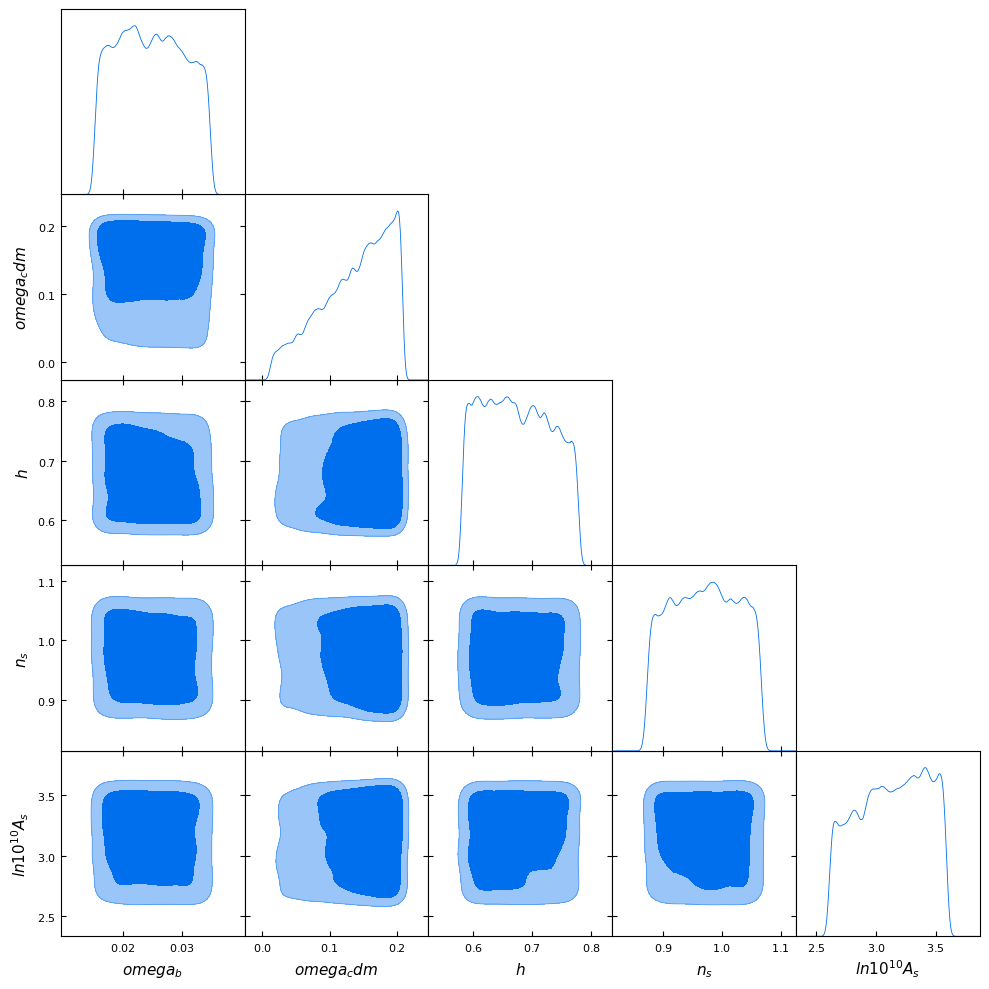

In [ ]:
import getdist
from getdist import MCSamples

# Convert the tensor 'a' (assumed shape: [num_samples, ndim]) to NumPy
samples_np = posterior_samples.detach().cpu().numpy()

# Define parameter names, e.g., from your varied_par_names
names = varied_par_names  # e.g., ['omega_b', 'omega_cdm', 'h', 'n_s', 'ln10^{10}A_s']

# Create an MCSamples object
mc_samples = MCSamples(samples=samples_np, names=names, labels=names)
fiducials = {p: fid_pars_dict[p][0] for p in varied_par_names}
from getdist import plots

g = plots.GetDistPlotter()

g.triangle_plot(
    [mc_samples],
    param_names=names,  # parameters to plot
    fiducial_values=fiducials,  # fiducial values overlay
    filled=True,
)

plt.show()